In [1]:
from ml.nodes import *
from ml.traces import *
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
MNIST = Datasets('MNIST', mnist)
MNIST.info()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
                                Datasets:        0     N:-1 C:784 
Dataset: MNIST
  shape: N:-1 C:784 
  labels: 10
  test:       (10000, 784)
  validation: (5000, 784)
  train:      (55000, 784)


In [3]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [4]:
x = MNIST.x
y_ = MNIST.y_

In [5]:
f = Flatten(MNIST)
l = Linear(f, 10)
b = Bias(l)
s = Softmax(b)
acc = Accuracy(s, y_)
cross_entropy = CrossEntropy(s, y_)

                                 Flatten:        0     N:-1 C:784 
                                  Linear:     7840     N:-1 C:10 
                                    Bias:       10     N:-1 C:10 
                                 Softmax:        0     N:-1 C:10 
                                Accuracy:        0     N:-1 C:1 
                            CrossEntropy:        0     N:-1 C:1 


In [6]:
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy.out())
sess.run(tf.global_variables_initializer())

In [7]:
trackables = [ [ ScalarTrace(acc.out(), 'Accuracy'), 
                 ScalarTrace(cross_entropy.out(), 'Cross Entropy'),
                 ScalarTrace(cross_entropy.out(), 'Cross Entropy', yFn='log', skip=100), ],
               [ BiasTrace(b.b, 'Bias'), WeightTrace(l.W, 'Weights'), SMTrace(b.out(), 'Out'),],
               [ SMTrace(s.out(), 'Softmax'),
                 SMTopTrace(s.out(), 'Softmax/Top'),
                 SMTopTrace(s.out(), 'Softmax/2nd', index=-2), ],
             ]

track = Track(trackables)

In [8]:
def train(track):
    nodes = track.nodes()
    for i in range(1000):
        for j in range(10):
            batch_xs, batch_ys = mnist.train.next_batch(100)
            vals = sess.run([train_step] + nodes, feed_dict={x: batch_xs, y_: batch_ys})
            track.addBatch(vals[1:])
        r = sess.run(nodes, feed_dict={x: mnist.validation.images, y_: mnist.validation.labels})
        track.addEpoch(r)

In [9]:
train(track)
f = sess.run(acc.out(), feed_dict={x: mnist.test.images, y_: mnist.test.labels})
print '%4.2f%%' % (f*100)

92.45%


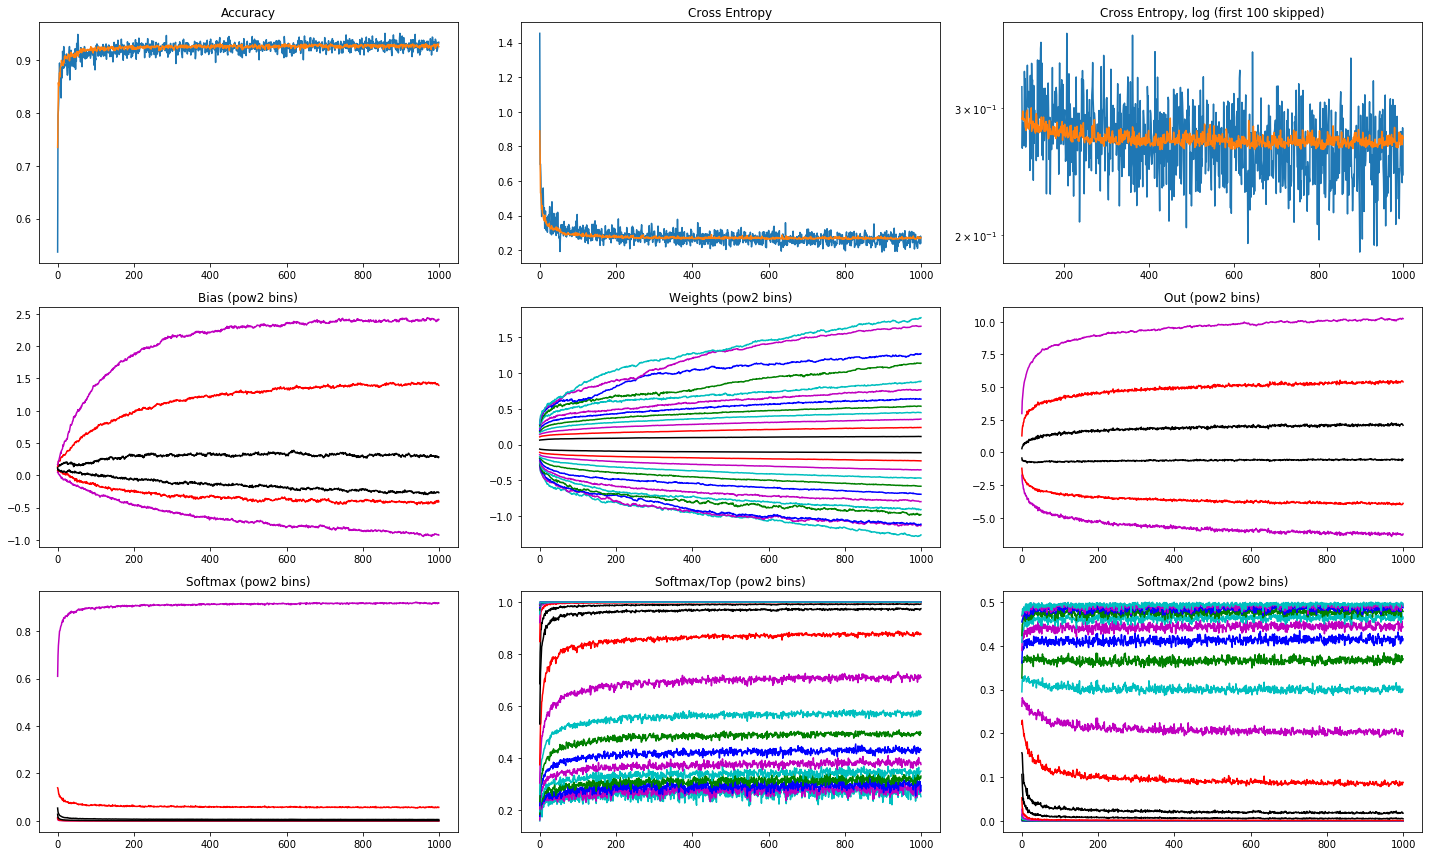

In [10]:
track.plotAll()